## 0. Download dataset

In [1]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view
# !pip install --upgrade gdown
# !gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
# !unzip -q icdar2003.zip -d datasets

In [17]:
!pip install -q scikit-learn
!pip install -U ultralytics

  Using cached ultralytics-8.3.51-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.13-py3-none-any.whl.metadata (9.4 kB)
Using cached ultralytics-8.3.51-py3-none-any.whl (901 kB)
Using cached ultralytics_thop-2.0.13-py3-none-any.whl (26 kB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.2.2
    Uninstalling ultralytics-8.2.2:
      Successfully uninstalled ultralytics-8.2.2


## 1. Import libraries

In [18]:
# %pip install -U ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.2 🚀 Python-3.11.5 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 11931MiB)
Setup complete ✅ (20 CPUs, 31.1 GB RAM, 594.8/915.3 GB disk)


In [6]:
# !yolo predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg'

In [19]:
import os
import shutil
import yaml
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in YOLO format

In [20]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall('taggedRectangles'):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib['x']), 
                        float(bb.attrib['y']), 
                        float(bb.attrib['width']), 
                        float(bb.attrib['height'])
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib['x']), int(image[1].attrib['y'])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [21]:
dataset_dir = 'datasets/SceneTrialTrain'
words_xml_path = os.path.join(
    dataset_dir,
    'words.xml'
)
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(words_xml_path)

## 3. Convert to YOLO format

In [22]:
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    yolov8_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolov8_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLOv8 format
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data

In [23]:
# Define class labels
class_labels = ['text']

# Convert data into YOLOv8 format
yolov8_data = convert_to_yolov8_format(
    image_paths, 
    image_sizes, 
    bounding_boxes
)

## 4. Train, val, test split

In [24]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolov8_data, 
    test_size=val_size, 
    random_state=seed,
    shuffle=is_shuffle
)
test_data, val_data = train_test_split(
    test_data, 
    test_size=test_size, 
    random_state=seed,
    shuffle=is_shuffle
)

## 5. Save data

In [25]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    for image_path, yolov8_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), 
            os.path.join(save_dir, 'images')
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")

In [26]:
save_yolo_data_dir = 'datasets/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(
    save_yolo_data_dir,
    'train'
)
save_val_dir = os.path.join(
    save_yolo_data_dir,
    'val'
)
save_test_dir = os.path.join(
    save_yolo_data_dir,
    'test'
)

save_data(
    train_data, 
    dataset_dir, 
    save_train_dir
)
save_data(
    test_data, 
    dataset_dir, 
    save_val_dir
)
save_data(
    val_data, 
    dataset_dir, 
    save_test_dir
)

## 6. Create yaml file

In [27]:
data_yaml = {
    'path': 'yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## 7. Training

In [28]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")


# Train the model
epochs = 50
imgsz = 1024
results = model.train(
    data=yolo_yaml_path, 
    epochs=epochs, 
    imgsz=imgsz,
    project='models',
    name='yolov11/detect/train'
)

AttributeError: Can't get attribute 'C3k2' on <module 'ultralytics.nn.modules.block' from '/home/aivn12s2/miniconda3/lib/python3.11/site-packages/ultralytics/nn/modules/block.py'>

## 8. Evaluation

In [29]:
from ultralytics import YOLO

model_path = 'models/yolov11/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project='models',
    name='yolov11/detect/val'
)  

AttributeError: Can't get attribute 'C3k2' on <module 'ultralytics.nn.modules.block' from '/home/aivn12s2/miniconda3/lib/python3.11/site-packages/ultralytics/nn/modules/block.py'>

## 9. Inference

In [15]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    
    for prediction in predictions:
        conf_score = prediction['confidence']
        
        if conf_score < conf_thres:
            continue
            
        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])
        
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

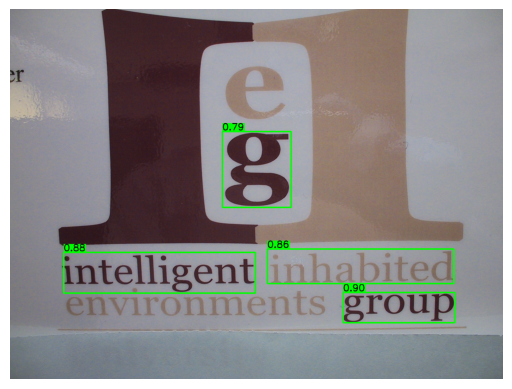

In [16]:
from ultralytics import YOLO

model_path = 'models/yolov11/detect/train/weights/best.pt'
img_path = 'datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1247.JPG'
conf_thres=0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()